# Tutorial 11f - Predicting Lens Misalignments Using Regression Models

This notebook demonstrates how to predict the XYZ misalignments of the three elements of a Cooke triplet using wavefront data from three field points. It leverages machine learning regression models to explore the predictive power of optical wavefront data.

In a separate notebook, we have generated a dataset of 1000 samples of random lens misalignments in XYZ. For each sample, we fit 36 Zernike standard coefficients to the wavefront map at 3 normalized field coordinates: (0, 0), (0, 0.7), (0, 1.0). The data is split into training, validation, and test sets, and preprocessed for improved regression model performance. The notebook compares multiple regression models, identifies the best-performing model, and validates its performance on both test and newly generated data.

The sections of this notebook are as follows:

1. Setup and Data Preparation: Load simulated data, preprocess it, and split it into training, validation, and test sets.
2. Model Selection and Training: Train multiple regression models and compare their performance on validation data.
3. Evaluation on Test Data: Validate the best model on test data and visualize its performance.
4. Validation with New Data from Optiland: Apply the model to new, simulated data from Optiland and evaluate its effectiveness.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from optiland import optic, wavefront, zernike

## Step 1: Setup and Data Preparation

This section sets up the dataset that will be used to train our model. The inputs represent Zernike coefficients fit to wavefront data for three field points, while the outputs represent the XYZ misalignments of three lenses. Data is split into training, validation, and test sets, and feature scaling is applied to ensure models handle the data effectively.

Key Steps:

1. Data Loading: Load the data, which was simulated in the `Build_Dataset.ipynb` notebook.
2. Data Splitting: Divide data into 70% training, 15% validation, and 15% testing for model development and evaluation.
3. Feature Scaling: Standardize the inputs for consistent scaling across models.

In [2]:
# load data
zernike_data = np.load("Cooke_triplet_wavefront_data.npy")
misalignment_data = pd.read_csv("Cooke_wavefront_data.csv")

We will plot a sample Zernike wavefront from the loaded data.

In [3]:
def plot_sample_zernike(index=0):
    z = zernike.ZernikeStandard(coeffs=zernike_data[index, 0, :])
    x, y = np.meshgrid(np.linspace(-1, 1, 512), np.linspace(-1, 1, 512))
    radius = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)

    data = z.poly(radius, phi)
    data[radius > 1] = np.nan

    plt.imshow(data, extent=(-1, 1, -1, 1))
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Zernike polynomial")
    plt.show()

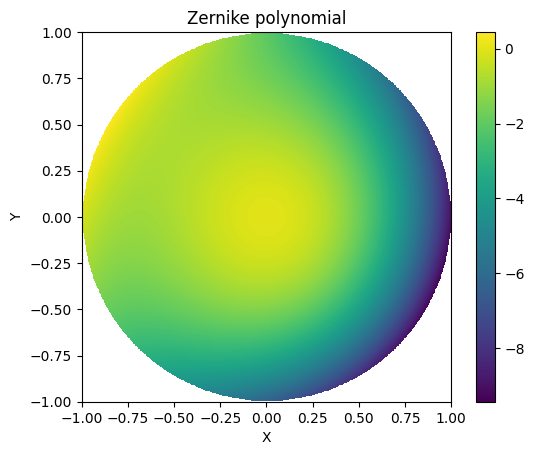

In [4]:
plot_sample_zernike(index=42)

In [5]:
X = zernike_data.reshape(zernike_data.shape[0], -1)
y = misalignment_data.to_numpy()

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Step 2: Model Selection and Training

In this section, we evaluate three machine learning regression models: Ridge Regression, Random Forest Regression, and a Multi-Layer Perceptron (MLP). Each model is trained on the scaled training data, and its performance is measured using Mean Squared Error (MSE) and R² on the validation set.

Key Steps:

1. Model Initialization: Define the hyperparameters for each regression model.
2. Training: Train each model on the training data.
3. Validation: Evaluate the models' performance on the validation data.
4. Comparison: Rank models by MSE to identify the most promising candidate.

Testing multiple models allows us to compare their performance and select the best one for our specific problem. Different models capture relationships in data differently. Ridge regression is linear, Random Forest is nonlinear but interpretable, and MLP provides a more complex, deep learning approach.

In [8]:
models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "MLP Regressor": MLPRegressor(
        hidden_layer_sizes=(64, 64),
        max_iter=500,
        random_state=42,
    ),
}

In [9]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    results[name] = {"MSE": mse, "R^2": r2}
    print(f"{name} -> MSE: {mse:.4f}, R^2: {r2:.4f}")

Ridge Regression -> MSE: 0.0006, R^2: 0.9916
Random Forest -> MSE: 0.0283, R^2: 0.6387
MLP Regressor -> MSE: 0.0173, R^2: 0.7789


## Step 3: Evaluate the Best Model on Test Data

After selecting the best model based on validation performance, we evaluate it on the held-out test set. The test set simulates unseen data, allowing us to measure the model’s generalization ability.

Key Steps:

1. Best Model Selection: Choose the model with the lowest validation MSE. For us, this is the Ridge regressor.
2. Test Set Evaluation: Compute metrics (MSE and R²) on the test set to quantify performance.
3. Visualization: Plot predicted vs. true misalignments to assess prediction quality.

In [10]:
# Choose the best-performing model (lowest MSE)
best_model_name = min(results, key=lambda x: results[x]["MSE"])
best_model = models[best_model_name]
y_test_pred = best_model.predict(X_test_scaled)

In [11]:
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nBest Model: {best_model_name}")
print(f"Test MSE: {test_mse:.4f} mm, Test R^2: {test_r2:.4f}")


Best Model: Ridge Regression
Test MSE: 0.0007 mm, Test R^2: 0.9915


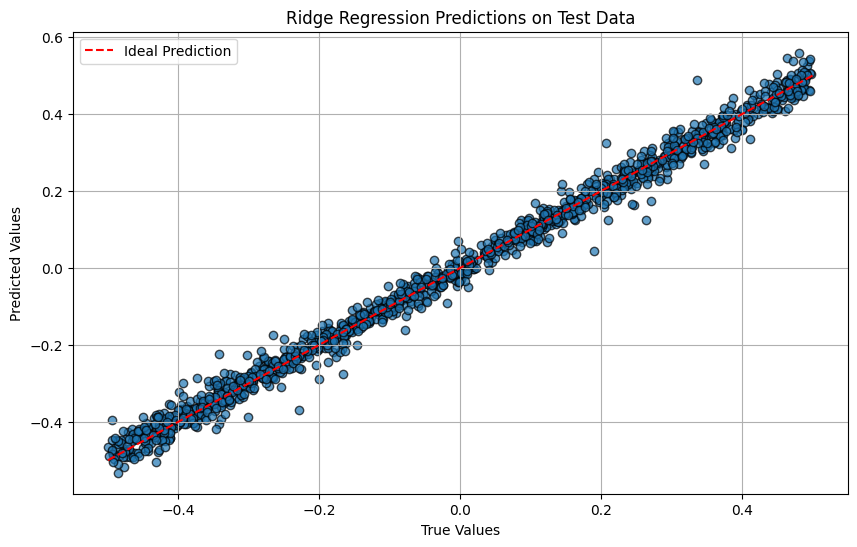

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors="k")
plt.plot([-0.5, 0.5], [-0.5, 0.5], "r--", label="Ideal Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_model_name} Predictions on Test Data")
plt.legend()
plt.grid()
plt.show()

While not perfect, the Ridge regressor is able to capture the underlying patterns in the data well, as indicated by its high R² score and low MSE on both the validation and test sets. However, there are still some discrepancies between the predicted and true values, indicating that there is room for improvement.

## Step 4: Validate with New Data from Optiland

This section validates the model using new data generated with Optiland. By applying the model to previously unseen, simulated data, we further evaluate its ability to generalize beyond the training distribution.

While technically not required, as the test data was also unseen by the model in the last section, this final validation also demonstrates how Optiland calculations integrate into the model workflow.

Key Steps:

1. New Data Simulation: Generate Zernike coefficients and misalignment targets from Optiland simulations.
2. Scaling: Preprocess the new data using the same scaling applied to the training data. This ensures no data leakage.
3. Prediction and Evaluation: Predict misalignments and compute MSE to measure performance.
4. Visualization: Compare predictions with true values using scatter plots to assess accuracy.

In [13]:
class CookeTriplet(optic.Optic):
    """Represents a Cooke triplet lens system with 3 lenses that can be misaligned."""

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset the Cooke triplet to its default configuration."""
        optic.Optic.__init__(self)  # reset full system

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(index=1, radius=22.01359, thickness=3.25896, material="SK16")
        self.add_surface(index=2, radius=-435.76044, thickness=6.00755)
        self.add_surface(
            index=3,
            radius=-22.21328,
            thickness=0.99997,
            material=("F2", "schott"),
        )
        self.add_surface(index=4, radius=20.29192, thickness=4.75041, is_stop=True)
        self.add_surface(index=5, radius=79.68360, thickness=2.95208, material="SK16")
        self.add_surface(index=6, radius=-18.39533, thickness=42.20778)
        self.add_surface(index=7)

        self.set_aperture(aperture_type="EPD", value=10)

        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=14)
        self.add_field(y=20)

        self.add_wavelength(value=0.55, is_primary=True)

    def decenter(self, lens_idx, dx=0, dy=0, dz=0):
        """Move a lens in the Cooke triplet system by a specified amount."""
        for idx in [lens_idx * 2 + 1, lens_idx * 2 + 2]:
            surf = self.surface_group.surfaces[idx]  # get surface
            cs = surf.geometry.cs  # get coordinate system

            # move surface
            cs.x += dx
            cs.y += dy
            cs.z += dz

    def randomly_misalign(self):
        """Randomly misalign the Cooke triplet lenses."""
        delta = np.random.uniform(-0.5, 0.5, size=(3, 3))
        for i in range(3):
            self.decenter(i, delta[i, 0], delta[i, 1], delta[i, 2])

        return delta.ravel().reshape(1, -1)

    def fit_zernike(self):
        """Fit the Cooke triplet wavefronts at 3 field points to Zernike polynomials."""
        coefficients = []
        for field in [0.0, 0.7, 1.0]:
            z = wavefront.ZernikeOPD(
                lens,
                field=(0, field),
                wavelength=0.55,
                zernike_type="standard",
                num_terms=36,
            )
            coefficients.append(z.coeffs)

        return np.array(coefficients).reshape(1, -1)

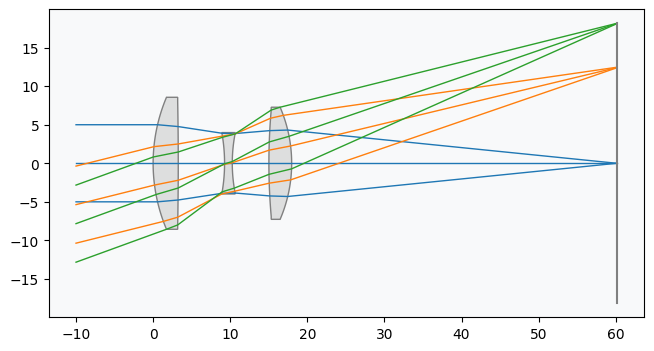

In [14]:
lens = CookeTriplet()
lens.draw()

In [15]:
# Randomly misalign the Cooke triplet
y_new_true = lens.randomly_misalign()

# Fit the Zernike coefficients
X_new = lens.fit_zernike()

# Scale the new data
X_new_scaled = scaler.transform(X_new)

# Predict the misalignment
y_new_pred = best_model.predict(X_new_scaled)

In [16]:
new_mse = mean_squared_error(y_new_true, y_new_pred)
print("\nPerformance on New Data:")
print(f"MSE: {new_mse:.4f} mm")


Performance on New Data:
MSE: 0.0003 mm


In [17]:
labels = [
    "Lens 1 dx1",
    "Lens 1 dy1",
    "Lens 1 dz1",
    "Lens 2 dx2",
    "Lens 2 dy2",
    "Lens 2 dz2",
    "Lens 3 dx3",
    "Lens 3 dy3",
    "Lens 3 dz3",
]
true_vs_pred = []

for i, label in enumerate(labels):
    true_value = y_new_true[0, i]
    pred_value = y_new_pred[0, i]
    true_vs_pred.append(
        f"{label}: True = {true_value:.3f} mm, Predicted = {pred_value:.3f} mm",
    )

for item in true_vs_pred:
    print(item)

Lens 1 dx1: True = 0.012 mm, Predicted = -0.008 mm
Lens 1 dy1: True = 0.081 mm, Predicted = 0.072 mm
Lens 1 dz1: True = -0.080 mm, Predicted = -0.076 mm
Lens 2 dx2: True = 0.380 mm, Predicted = 0.368 mm
Lens 2 dy2: True = -0.135 mm, Predicted = -0.138 mm
Lens 2 dz2: True = 0.353 mm, Predicted = 0.365 mm
Lens 3 dx3: True = -0.045 mm, Predicted = -0.064 mm
Lens 3 dy3: True = -0.389 mm, Predicted = -0.378 mm
Lens 3 dz3: True = -0.474 mm, Predicted = -0.436 mm


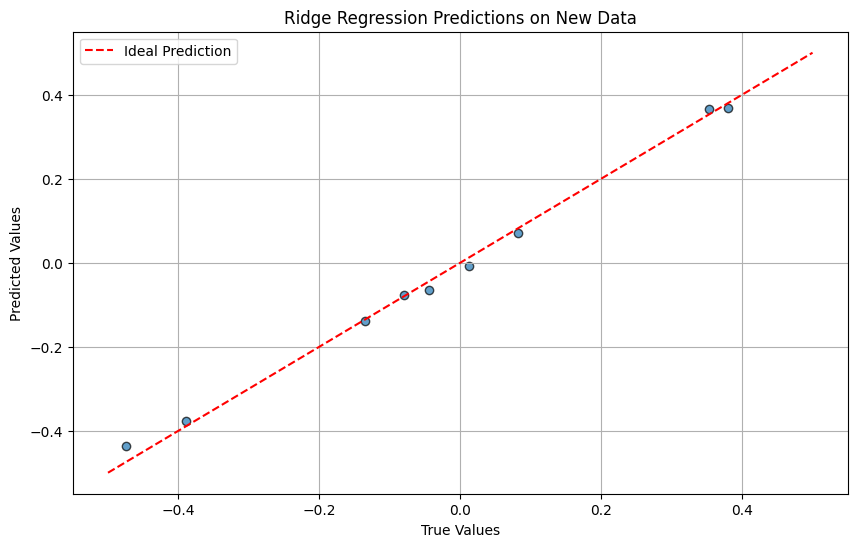

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_new_true, y_new_pred, alpha=0.7, edgecolors="k")
plt.plot([-0.5, 0.5], [-0.5, 0.5], "r--", label="Ideal Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_model_name} Predictions on New Data")
plt.legend()
plt.grid()
plt.show()

## Conclusions

This notebook demonstrates how regression models can predict lens misalignments of a Cooke triplet using Zernike coefficients as inputs. By comparing models, validating performance, and testing on new data, we achieve a robust understanding of the problem and (one possible) solution.

Key takeaways:

1. Wavefront data encoded as Zernike coefficients can effectively predict lens misalignments.
2. For this problem, Ridge regression significantly outperforms both Random Forests and a MLP. This shows that more complex models are not always the best option and that linear models often are the best approach.